In [1]:
import os
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize  
from sklearn.feature_extraction.text import CountVectorizer
import collections
from sklearn import metrics

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_20newsgroups
%matplotlib inline

### Užkrauname duomenų rinkinį
 Pasirenkame tik 5 kategorijas, pasirinktos kategorijos ir atitinkamų kategorijų dydžiai parodyti grafike žemiau

Kategorijos:
	comp.windows.x
	sci.space
	rec.motorcycles
	rec.sport.hockey
	soc.religion.christian

Iš viso 4967 dokumentų


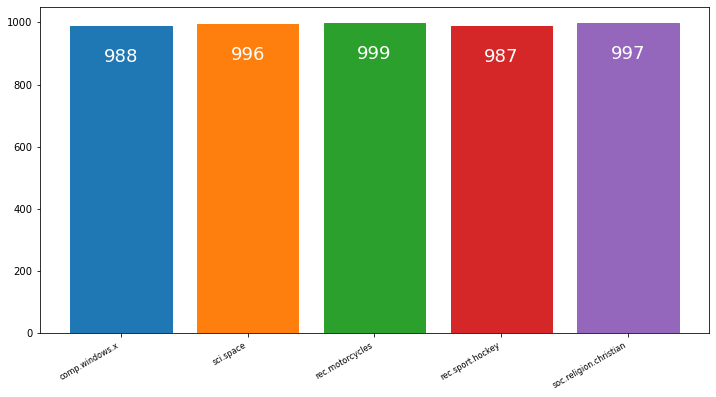

In [2]:
cats = ['comp.windows.x', 'sci.space', 'rec.motorcycles', 'rec.sport.hockey', 'soc.religion.christian']
data = fetch_20newsgroups(subset='all', categories=cats)

print("Kategorijos:")
for cat in cats:
    print("\t{}".format(cat))

texts = data.data
label = data.target
print("\nIš viso {} dokumentų".format(len(texts)))

(unique, counts) = np.unique(label, return_counts=True)

fig, ax = plt.subplots(1,1,figsize=(12,6))


ax.bar(range(len(cats)), counts)
ax.set_xticks(range(len(cats)))
ax.set_xticklabels(cats, rotation=30, ha='right', fontsize=8)


for rect, c, value in zip(ax.patches, ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive'], counts):
    rect.set_color(c)
    height = rect.get_height()
    width = rect.get_width()
    x_loc = rect.get_x()
    ax.text(x_loc + width/2, 0.9*height, value, ha='center', va='center', fontsize=18, color='white')

##### Apžvelkime kokio ilgio mūsų tekstai

In [3]:
dokumentu_ilgiai = []
for text in texts:
    dokumentu_ilgiai.append(len(text.split(' ')))
    
print("Vidutinis tekstų ilgis: {} žodis".format(round(sum(dokumentu_ilgiai)/len(dokumentu_ilgiai))))
print("Trumpiausias tekstas: {} žodiai".format(min(dokumentu_ilgiai)))
print("Ilgiausias tekstas: {} žodiai".format(max(dokumentu_ilgiai)))

Vidutinis tekstų ilgis: 335 žodis
Trumpiausias tekstas: 9 žodiai
Ilgiausias tekstas: 20235 žodiai


Matome, kad yra labai trumpų dokumentų ir labai ilgų.. Tai galime matyti ir grafiškai, kad pagrine tekstai yra iki 500 žodžių

C:\Users\user2\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(-50.0, 2300.0)

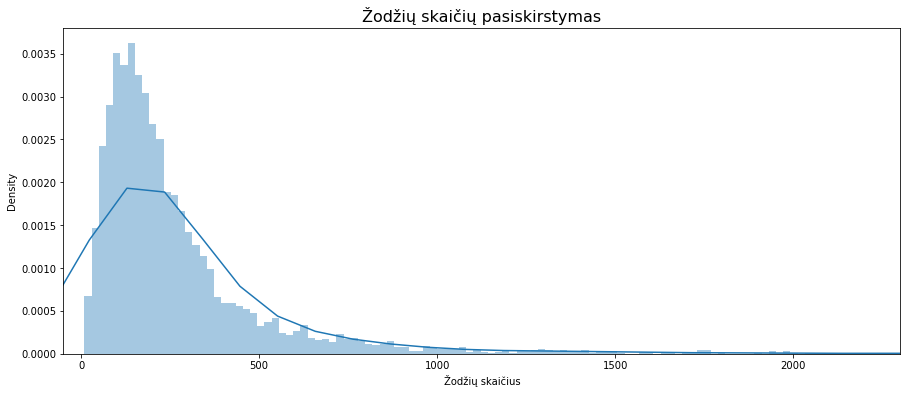

In [4]:
fig, ax = plt.subplots(figsize=(15,6))

ax.set_title("Žodžių skaičių pasiskirstymas", fontsize=16)
ax.set_xlabel("Žodžių skaičius")
sns.distplot(dokumentu_ilgiai, bins=1000, ax=ax);
plt.xlim(-50, 2300)

### Duomenų rinkinio paruošimas
* Paverčiam visą tekstą iš mažųjų raidžių
* Iš teksto pašaliname skaičius
* Pašaliname email'us
* Panaikiname simbolius, kurie nėra raidės: "[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]"
* Pašaliname nereikšmingus žodžius ir žodžius kuriu ilgis yra trumpesnis nei 3 raidės

In [5]:
stop_words = stopwords.words('english')
stop_wrds = ''
for wrd in stop_words:
    stop_wrds += wrd + ' '
stop_words = stop_wrds.translate(str.maketrans('', '', string.punctuation))
stop_words = set(word_tokenize(stop_words))


preprocessed_texts = []
for text in texts:
    tmp = text.lower() # visos raides mazosios
    tmp = re.sub(r'\d+', '', tmp) # panaikinam skaicius
    tmp = ' '.join([w for w in tmp.split() if '@' not in w]) # panaikinam email'us
    tmp = tmp.translate(str.maketrans('', '', string.punctuation)) # panaikinti [!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~]
    word_tokens = word_tokenize(tmp)
    tmp = [w for w in word_tokens if (not w in stop_words and len(w)>2)] # panaikinam nereiksmingus zodzius ir trumpesnius nei 2 raides
    
    preprocessed_texts.append(tmp)

### Sudarome žodyną

In [6]:
def word_dict(texts):
    zodynas = {}
    for text in texts:
        for word in text:
            try:
                zodynas[word].add(1)
            except:
                zodynas[word] = zodynas.get(word, 0) + 1
    
    mx_count = len(texts)//1.8
#    values = np.array(list(zodynas.values()))
#    dict_words = np.array(list(zodynas))
#   idx = np.where((values > 10) & (values < mx_count))
#   new_dict = dict_words[idx]
    
#    unwanted = set(zodynas) - set(new_dict)
#    for unwanted_key in unwanted: del zodynas[unwanted_key]
        
    return zodynas

zodynas = word_dict(preprocessed_texts)
print("Žodyną sudaro {} žodžiai".format(len(zodynas)))



Žodyną sudaro 52672 žodžiai


Grafike žemiau matome dažniausiai pasitaikančius žodžius mūsų tekstuose, remiantis šiuo grafiku galime iš žodynp išmesti žodžius pasitaikančius dažniau negu 2000 kartų

C:\Users\user2\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Dažniausiai pasitaikantys žodžiai')

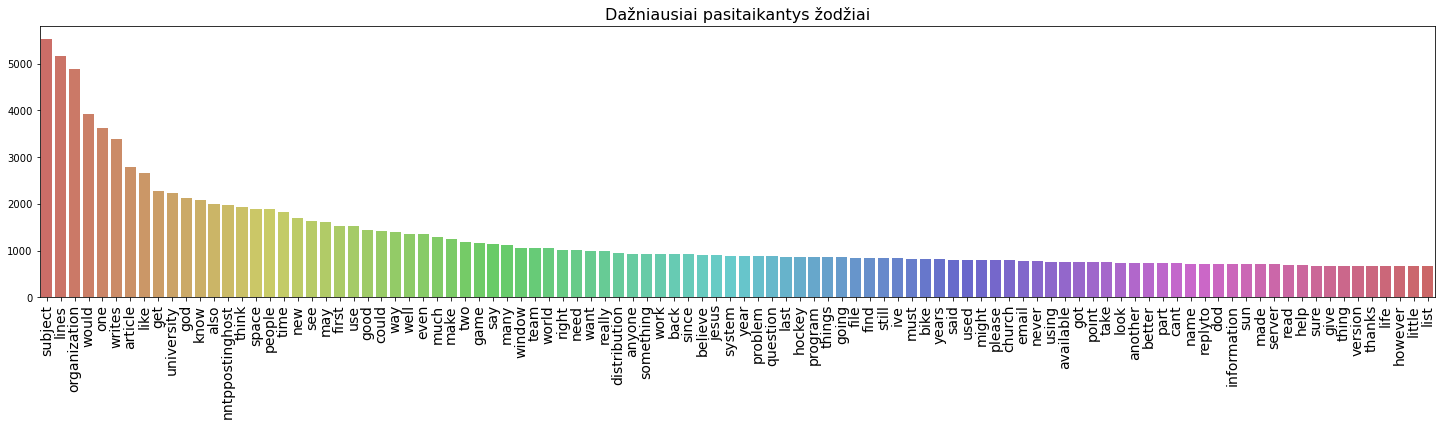

In [7]:
zodis, daznis = zip(*sorted(zodynas.items(), key=lambda kv: kv[1]))


fig, ax = plt.subplots(1,1,figsize=(25,5))
sns.barplot(list(range(100)), np.array(daznis[-100:][::-1]), palette='hls', ax=ax)
ax.set_xticks(list(range(100)))
ax.set_xticklabels(zodis[-100:][::-1], fontsize=14, rotation=90)
ax.set_title("Dažniausiai pasitaikantys žodžiai", fontsize=16)


Išmetame labai dažnus ir labai retus žodžius, nes tai gali būti labai unikalūs žodžiai arba tiesiog gramatinės klaidos

In [8]:
x = np.array(list(zodynas.values()))
dict_words = np.array(list(zodynas))
mx_count = 2000
idx = np.where((x > 10) & (x < mx_count))
new_dict = dict_words[idx]
    
unwanted = set(zodynas) - set(new_dict)
for unwanted_key in unwanted: del zodynas[unwanted_key]

print("Po labai dažnų ir labai retų žodžių pašalinimo žodyne liko {} žodžiai".format(len(zodynas)))
zodziai_isvalyti, dazniai_isvalyti = zip(*sorted(zodynas.items(), key=lambda kv: kv[1]))

Po labai dažnų ir labai retų žodžių pašalinimo žodyne liko 8282 žodžiai


### Sudarome dokumentų vektorius pagal "Žodžių maišą"

In [9]:
n = len(zodynas)
zodynas_sarasas = np.array([*zodynas])

BOW_vectors = []

for doc in preprocessed_texts:
    tmp_vec = [0]*n
    for word in doc:
        if word in zodynas:
            idx = np.where(zodynas_sarasas==word)[0][0]
            tmp_vec[idx] += 1
    BOW_vectors.append(tmp_vec)


### Sudarome dokumentų vektorius pagal TF-IDF statistiką

In [10]:
N = len(preprocessed_texts)

tf_idf_vectors = []
    
for doc in preprocessed_texts:
    tf_idf = {}
        
    counter = collections.Counter(doc)
    for token in np.unique(doc):
        #print(token)
        try:
            tf = counter[token]/len(doc) # zodzio daznumas tekste / zodziu skaicius tekste
            df = zodynas[token] # Dokumentu skaicius kuriame yra sis zodis
            idf = np.log(N/(df+1))
            tf_idf[token] = tf*idf
        except:
            pass
            
    tf_idf_stack = np.vstack((list(tf_idf.keys()), list(tf_idf.values()))).transpose()
        
    finger_print = np.zeros(len(zodynas), np.float)
        
    for word in doc:
        if word in zodynas:
                #print(np.where(np.array(dictionary)==word))
            finger_print[np.where(zodynas_sarasas == word)] = float(tf_idf_stack[np.where(tf_idf_stack[:,0] == word),1])
        
    #finger_print = word_from_dictionary_2(processed_text[i], dictionary, tf_idf_stack, n_list = 1)
    tf_idf_vectors.append(finger_print)

### WORD2VEC MODEL

In [11]:
from gensim.models import Word2Vec

word2vec = Word2Vec(preprocessed_texts, min_count=10)

In [12]:
vocabulary = word2vec.wv.vocab


Similar words

In [13]:
#w1 = word2vec.wv['adam']
sim_words = word2vec.wv.most_similar('men')
print(sim_words)

[('shall', 0.9882668852806091), ('death', 0.9875876903533936), ('son', 0.986469566822052), ('born', 0.985538125038147), ('resurrection', 0.9847413301467896), ('lord', 0.9831116199493408), ('sins', 0.9831074476242065), ('mother', 0.9826205968856812), ('heaven', 0.9807409644126892), ('christ', 0.9805834293365479)]


DOC2VEC

In [14]:
from gensim.models import doc2vec

TAG texts for doc2vec

In [15]:
def tagged_document(list_of_list_of_words):
   for i, list_of_words in enumerate(list_of_list_of_words):
      yield doc2vec.TaggedDocument(list_of_words, [i])
data_for_training = list(tagged_document(preprocessed_texts))

In [158]:
model = doc2vec.Doc2Vec(vector_size = 128, min_count = 10, epochs=30)

In [159]:
model.build_vocab(data_for_training)

In [160]:
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [161]:
def doc2vec_vectorizer(model, preprocessed_texts):
    tmp_vec = []
    for text in preprocessed_texts:
        tmp_vec.append(model.infer_vector(text))
    return tmp_vec

###### doc2vec embedding

In [162]:
doc2vec_vectors = doc2vec_vectorizer(model, preprocessed_texts)

#### TODO:
BERT embeddings

In [102]:
np.array(BOW_vectors).shape

(8824, 11462)

***

# Klasterizacija

In [21]:
vektorizavimo_algoritmai = ['Žodžių maišas', 'TF-IDF statistika', 'word2vec', 'BERT']

## K-vidurkių

Funkcija skirta k klasterių skaičiui nustatyti

In [22]:
def k_means_check(X):
    inertia = []
    sil = []# changing the number of clusters 
    for k in range(2,8):

        km = KMeans(n_clusters=k, random_state=144)
        km.fit(X)
        y_pred = km.predict(X)

        inertia.append((k, km.inertia_))
        sil.append((k, silhouette_score(X, y_pred)))
        
        
    fig, ax = plt.subplots(1,2, figsize=(12,4))

    # Plotting Elbow Curve
    x_iner = [x[0] for x in inertia]
    y_iner  = [x[1] for x in inertia]
    ax[0].plot(x_iner, y_iner)
    ax[0].set_xlabel('Number of Clusters')
    ax[0].set_ylabel('Intertia')

    # Plotting Silhouetter Score
    ax[0].set_title('Elbow Curve')
    x_sil = [x[0] for x in sil]
    y_sil  = [x[1] for x in sil]
    ax[1].plot(x_sil, y_sil)
    ax[1].set_xlabel('Number of Clusters')
    ax[1].set_ylabel('Silhouetter Score')
    ax[1].set_title('Silhouetter Score Curve')


### TF-IDF

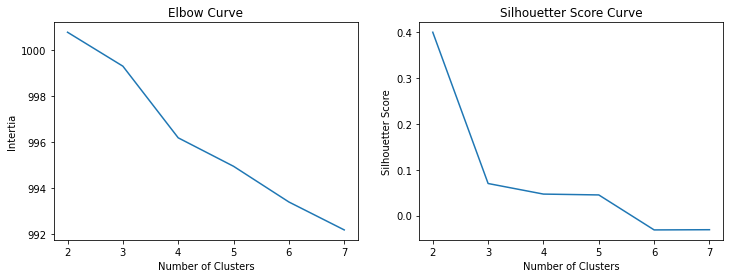

In [23]:
k_means_check(tf_idf_vectors)

Iš grafikų matome, kad galime rinktis k=3 arba k=4

Tarkime pasirenkame k=4

In [24]:
km = KMeans(n_clusters=4, random_state=144)
km.fit(tf_idf_vectors)
tf_idf_pred = km.predict(tf_idf_vectors)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

##### Apžvelkime kokie žodžiai sudaro atitinkamus klasterius

In [26]:
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        #print(ind)
        print(' %s' % zodynas_sarasas[ind])

Cluster 0:
 elements
 element
 twoline
 kelso
 orbital
 celestial
 shuttle
 updated
 daily
 bbs
Cluster 1:
 daily
 chuck
 grass
 verse
 valley
 petch
 proverbs
 group
 whoever
 peace
Cluster 2:
 nntppostinghost
 bike
 dod
 game
 distribution
 replyto
 anyone
 think
 good
 usa
Cluster 3:
 thanks
 window
 internet
 motif
 email
 windows
 server
 xterm
 help
 please


### BOW (Žodžių maišas)

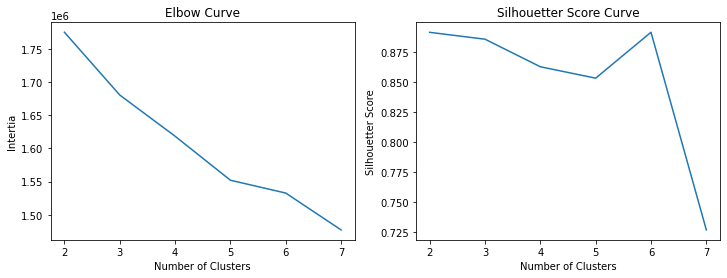

In [27]:
k_means_check(BOW_vectors)

Iš grafikų matome, kad galime rinktis k=5 arba k=6 

Tarkime pasirenkame k=6

In [29]:
km = KMeans(n_clusters=6, random_state=144)
km.fit(BOW_vectors)
BOW_pred = km.predict(BOW_vectors)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(6):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        #print(ind)
        print(' %s' % zodynas_sarasas[ind])

Cluster 0:
 nntppostinghost
 think
 people
 space
 also
 time
 new
 see
 may
 first
Cluster 1:
 entry
 entries
 rules
 program
 use
 section
 files
 must
 info
 file
Cluster 2:
 file
 oname
 output
 program
 char
 entry
 stream
 eofnotok
 contest
 line
Cluster 3:
 hockey
 league
 nhl
 new
 team
 season
 games
 draft
 division
 teams
Cluster 4:
 openwindows
 use
 also
 see
 look
 sun
 xview
 open
 file
 window
Cluster 5:
 available
 window
 widget
 version
 server
 use
 also
 file
 motif
 software


### DOC2VEC 

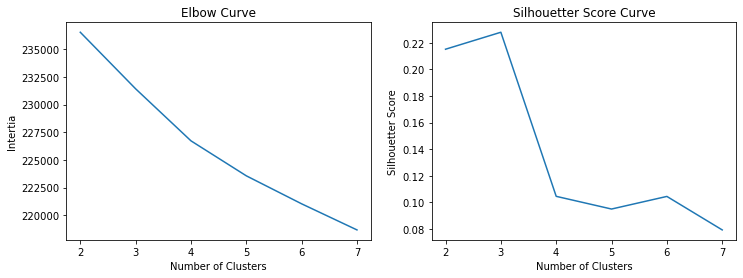

In [163]:
%matplotlib inline
k_means_check(doc2vec_vectors)

In [164]:
km = KMeans(n_clusters=5, random_state=144)
km.fit(doc2vec_vectors)
DOC2VEC_pred = km.predict(doc2vec_vectors)
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(5):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        #print(ind)
        print(' %s' % zodynas_sarasas[ind])

Cluster 0:
 boston
 maine
 fred
 original
 mark
 miller
 west
 rosters
 greg
 ryan
Cluster 1:
 farenell
 rosters
 maine
 matt
 mark
 johnson
 cup
 actual
 cornell
 campbell
Cluster 2:
 boston
 matt
 roberts
 clarkson
 mark
 johnson
 point
 farenell
 allstar
 dan
Cluster 3:
 mark
 yale
 dan
 point
 johnson
 farenell
 allstar
 original
 rosters
 wood
Cluster 4:
 greg
 jamie
 campbell
 roberts
 glens
 matt
 wood
 participate
 cornell
 high


### Klasterizavimo įvertinimas
Klasterizavimo vertinimui pasirinkime **rand index** kriterijų, šis kriterijus matuoja panašuma tarp dviejų klasterių duomenų rinkinių.

**Rand index** gali įgauti reikšmes tarp 0 ir 1, čia:

0 - reiškia, kad du suklasterizuoti rinkiniai yra visiškai skirtingi ir neturi bendrų elementų klasteriuose.

1 - reiškia, kad du duomenų rinkiniai suklasterizuoti identiškai.

***
Mūsų atvėju mes turime tikruosius duomenų žymėjimus *(label)* ir žymėjimus kuriuos priskyrė klasterizavimo algoritmas 

In [147]:
from scipy.special import comb

def rand_index_score(clusters, classes):
    tp_plus_fp = comb(np.bincount(clusters), 2).sum()
    tp_plus_fn = comb(np.bincount(classes), 2).sum()
    A = np.c_[(clusters, classes)]
    tp = sum(comb(np.bincount(A[A[:, 0] == i, 1]), 2).sum()
             for i in set(clusters))
    fp = tp_plus_fp - tp
    fn = tp_plus_fn - tp
    tn = comb(len(A), 2) - tp - fp - fn
    return (tp + tn) / (tp + fp + fn + tn)

In [165]:
print("Rand index scores: \n \tTF-IDF rand score: {}\n \tBOW rand score: {}\n \tDOC2VEC rand score {}".format(round(rand_index_score(label, tf_idf_pred), 2), round(rand_index_score(label, BOW_pred), 2), round(rand_index_score(label, DOC2VEC_pred), 2)))

Rand index scores: 
 	TF-IDF rand score: 0.5
 	BOW rand score: 0.2
 	DOC2VEC rand score 0.64


TODO: gal pasirinkti dar vieną klasterizavimo vertinimo kriterijų?? pvz. **mutual information score**

In [166]:
metrics.mutual_info_score(label, DOC2VEC_pred)

0.6327872459054089

In [167]:
DOC2VEC_pred

array([4, 1, 2, ..., 3, 2, 2])

## VIZUALIZACIJA

In [168]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA

In [169]:
cls = MiniBatchKMeans(n_clusters=5, random_state=144)
cls.fit(doc2vec_vectors)

MiniBatchKMeans(n_clusters=5, random_state=144)

In [170]:
cls.predict(doc2vec_vectors)
cls.labels_

array([0, 3, 0, ..., 0, 0, 0])

In [171]:
pca = PCA(n_components=3, random_state=144)
reduced_features = pca.fit_transform(np.array(doc2vec_vectors))

In [172]:
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

In [177]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

%matplotlib qt
fig = pyplot.figure()
ax = Axes3D(fig)

sequence_containing_x_vals = list(reduced_features[:,0])
sequence_containing_y_vals = list(reduced_features[:,1])
sequence_containing_z_vals = list(reduced_features[:,2])


ax.scatter(sequence_containing_x_vals, sequence_containing_y_vals, sequence_containing_z_vals, c=cls.predict(doc2vec_vectors), s=10)
ax.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], reduced_cluster_centers[:,2], marker='d', s=1000, c='r')


In [182]:

plt.scatter(reduced_features[:,0], reduced_features[:,1], c=cls.predict(doc2vec_vectors))
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='d', s=150, c='r')

## GMM

Text(0.5, 0, 'n_components')

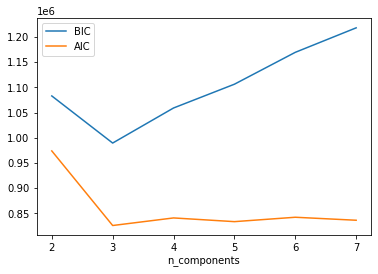

In [232]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
X = doc2vec_vectors
n_components = np.arange(2, 8)
models = [GaussianMixture(n, covariance_type='full', random_state=144).fit(X) for n in n_components]

plt.plot(n_components, [m.bic(np.array(X)) for m in models], label='BIC')
plt.plot(n_components, [m.aic(np.array(X)) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

In [236]:
#Gaussian Mixture Model
gmm = GaussianMixture(n_components=5)
gmm.fit(X)
proba_lists = gmm.predict_proba(X)


In [237]:
colored_arrays = np.matrix(proba_lists)
colored_tuples = [tuple(i.tolist()[0]) for i in colored_arrays]

gmm_col = []
for t in colored_tuples:
    gmm_col.append(np.argmax(t))
np.unique(gmm_col, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([1965,  259,  649, 1562,  532], dtype=int64))

In [238]:
#Plotting
%matplotlib qt

fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2],
           edgecolor="k", s=50, c=gmm_col)
plt.title("Gaussian Mixture Model", fontsize=14)

Text(0.5, 0.92, 'Gaussian Mixture Model')

# EVAL

In [239]:

from sklearn.metrics import homogeneity_score
homogeneity_score(label, gmm_col)#cls.predict(doc2vec_vectors))

0.24431916163723483

In [241]:
from sklearn.metrics import silhouette_score
silhouette_score(doc2vec_vectors, gmm_col)#labels=cls.predict(doc2vec_vectors))

-0.012935143